In [11]:
# 7.16.20

### Notes
- Extract text from json.
- Build simple models and check results.


#### Data
- all_train_with_org.json
- all_dev_with_org.json
- all_test_with_org.json
- china_test_with_org.json [PROBLEMATIC]

In [18]:
import json
import random
import pickle
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,precision_recall_fscore_support,classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
%matplotlib inline
stopwords = stopwords.words('english')

# 1. Data Preparation and Preprocessing

In [2]:
DATAPATH = "../data/ProtestNews2019/"

In [3]:
def create_dataframe(list_of_articles):
    data = [[article['id'],article['url'],' '.join(article['text'].split('\n')),article['label']] for article in list_of_articles]
    return pd.DataFrame(data,columns=['id','url','text','label'])

In [4]:
train_data = []
with open(DATAPATH+'all_train_with_org.json', 'rb') as f:
        for line in f:
            d = json.loads(line)
            train_data.append(d)
            
dev_data = []
with open(DATAPATH+'all_dev_with_org.json', 'rb') as f:
        for line in f:
            d = json.loads(line)
            dev_data.append(d)
            
test_data = []
with open(DATAPATH+'all_test_with_org.json', 'rb') as f:
        for line in f:
            d = json.loads(line)
            test_data.append(d)

china_data = []
with open(DATAPATH+'china_test_with_org.json', 'rb') as f:
        for line in f:
            d = json.loads(line)
            china_data.append(d)

In [5]:
df_train = create_dataframe(train_data)
df_train.label.value_counts()

0.0    2723
1.0     856
Name: label, dtype: int64

In [6]:
df_dev = create_dataframe(dev_data)
df_dev.label.value_counts()

0    355
1    102
Name: label, dtype: int64

In [7]:
df_test = create_dataframe(test_data)
df_test.label.value_counts()

0    533
1    154
Name: label, dtype: int64

In [8]:
# org_text and text??
#df_china = create_dataframe(china_data)
#df_china.label.value_counts()

In [9]:
# preprocessing function 
    # split an article into sentences
        # go to each sentence and split it to words
            # if this word  is not in stopwords or other common words I've decided
                #AND
                   # if its alphabetic (getting rid of puctuation and numbers)
                        #AND
                            # if len of the word is greater than 2
                            
                            # lemmatize and lowercase the the word
                            
                            # return the cleaned article
def preprocess(news):
    l = WordNetLemmatizer()
    sentences = news.split(".")
    return " ".join([l.lemmatize(word.lower()) for sentence in sentences for word in sentence.split() if word not in stopwords if word.isalpha() if len(word)> 2 if word.lower() not in ["said","the","first","also","would","one","two","they"]])

In [10]:
train = df_train.iloc[:,-2:]
train['text'] = train['text'].map(preprocess)

dev = df_dev.iloc[:,-2:]
dev['text'] = dev['text'].map(preprocess)

test = df_test.iloc[:,-2:]
test['text'] = test['text'].map(preprocess)

# 2. Models and Experiments

## 2.1 SVM and Experiments

In [35]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC()),
])

hyperparameters = dict(
    tfidf__min_df      = (4, 10, 16),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
    clf__kernel        = ["linear", "poly","sigmoid"],
    clf__gamma         = ('scale', 'auto'),
    clf__C             = np.logspace(1,4,6)

)

svc_grid_search = GridSearchCV(svc_pipeline, hyperparameters,cv=3,scoring='f1_macro')

svc_grid_search.fit(train.text, list(train.label))

svc_grid_search.best_score_

0.8490360243985743

In [36]:
svc_grid_search.best_params_

{'clf__C': 10.0,
 'clf__gamma': 'scale',
 'clf__kernel': 'linear',
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

In [38]:
print(classification_report(list(dev.label),
                            svc_grid_search.predict(dev.text)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       355
           1       0.83      0.67      0.74       102

    accuracy                           0.89       457
   macro avg       0.87      0.81      0.84       457
weighted avg       0.89      0.89      0.89       457



In [39]:
confusion_matrix(list(dev.label),svc_grid_search.predict(dev.text))

array([[341,  14],
       [ 34,  68]], dtype=int64)

In [41]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

svc_model.fit(train.text, list(train.label))

confusion_matrix(list(train.label),svc_grid_search.predict(train.text))

array([[2723,    0],
       [   0,  856]], dtype=int64)

In [42]:
filename = 'svc_model.sav'
pickle.dump(svc_model, open("../models/"+filename, 'wb'))

### Try Different Ratios Of Data

In [49]:
results = []

### All

In [45]:
len(train.index)

3579

In [50]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

svc_model.fit(train.text, list(train.label))

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degr

In [51]:
print(classification_report(list(dev.label),svc_model.predict(dev.text)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       355
           1       0.83      0.67      0.74       102

    accuracy                           0.89       457
   macro avg       0.87      0.81      0.84       457
weighted avg       0.89      0.89      0.89       457



In [52]:
print(classification_report(list(test.label),svc_model.predict(test.text)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       533
           1       0.84      0.75      0.79       154

    accuracy                           0.91       687
   macro avg       0.89      0.86      0.87       687
weighted avg       0.91      0.91      0.91       687



### 10%

In [58]:
train_10 = train.sample(3200,random_state=22)

In [59]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

svc_model.fit(train_10.text, list(train_10.label))

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degr

In [60]:
print(classification_report(list(dev.label),svc_model.predict(dev.text)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       355
           1       0.86      0.69      0.77       102

    accuracy                           0.91       457
   macro avg       0.89      0.83      0.85       457
weighted avg       0.90      0.91      0.90       457



In [61]:
print(classification_report(list(test.label),svc_model.predict(test.text)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       533
           1       0.83      0.75      0.78       154

    accuracy                           0.91       687
   macro avg       0.88      0.85      0.86       687
weighted avg       0.91      0.91      0.91       687



### 20%

In [63]:
train_20 = train.sample(2850,random_state=11)

In [69]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

svc_model.fit(train_20.text, list(train_20.label))

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degr

In [70]:
print(classification_report(list(dev.label),svc_model.predict(dev.text)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       355
           1       0.82      0.67      0.74       102

    accuracy                           0.89       457
   macro avg       0.86      0.81      0.83       457
weighted avg       0.89      0.89      0.89       457



In [71]:
print(classification_report(list(test.label),svc_model.predict(test.text)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       533
           1       0.79      0.73      0.76       154

    accuracy                           0.90       687
   macro avg       0.86      0.84      0.85       687
weighted avg       0.89      0.90      0.89       687



### 50%

In [67]:
train_50 = train.sample(1850,random_state=11)

In [72]:
svc_model = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
    ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

svc_model.fit(train_50.text, list(train_50.label))

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degr

In [73]:
print(classification_report(list(dev.label),svc_model.predict(dev.text)))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       355
           1       0.80      0.63      0.70       102

    accuracy                           0.88       457
   macro avg       0.85      0.79      0.81       457
weighted avg       0.88      0.88      0.88       457



In [74]:
print(classification_report(list(test.label),svc_model.predict(test.text)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       533
           1       0.79      0.71      0.75       154

    accuracy                           0.89       687
   macro avg       0.85      0.83      0.84       687
weighted avg       0.89      0.89      0.89       687



In [92]:
classification_report(list(test.label),svc_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]

[' 0.85', '0.83', '0.84']

In [152]:
ran = list(range(100,3579,100))
ran.append(3579)

In [153]:
dev_r = {"p":[],"r":[],"f":[]}
test_r = {"p":[],"r":[],"f":[]}

for r in ran:
    d_p,d_r,d_f = [],[],[]
    t_p,t_r,t_f = [],[],[]
    for _ in range(10):
        t = train.sample(r,random_state=random.sample(range(100),1)[0])
        svc_model = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
        ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

        svc_model.fit(t.text, list(t.label))
    
        d_res = classification_report(list(dev.label),svc_model.predict(dev.text)).split('\n')[6].split('      ')[1:-1]
        d_p.append(float(d_res[0]))
        d_r.append(float(d_res[1]))
        d_f.append(float(d_res[2]))
        
        t_res = classification_report(list(test.label),svc_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]
        t_p.append(float(t_res[0]))
        t_r.append(float(t_res[1]))
        t_f.append(float(t_res[2]))
        
    dev_r["p"].append(sum(d_p)/len(d_p))
    dev_r["r"].append(sum(d_r)/len(d_r))
    dev_r["f"].append(sum(d_f)/len(d_f))
    
    test_r["p"].append(sum(t_p)/len(t_p))
    test_r["r"].append(sum(t_r)/len(t_r))
    test_r["f"].append(sum(t_f)/len(t_f))

In [156]:
filename = 'dev_r.pickle'
pickle.dump(dev_r, open("../data/"+filename, 'wb'))

filename = 'test_r.pickle'
pickle.dump(test_r, open("../data/"+filename, 'wb'))

with open('../da.pickle', 'rb') as handle:
    b = pickle.load(handle)

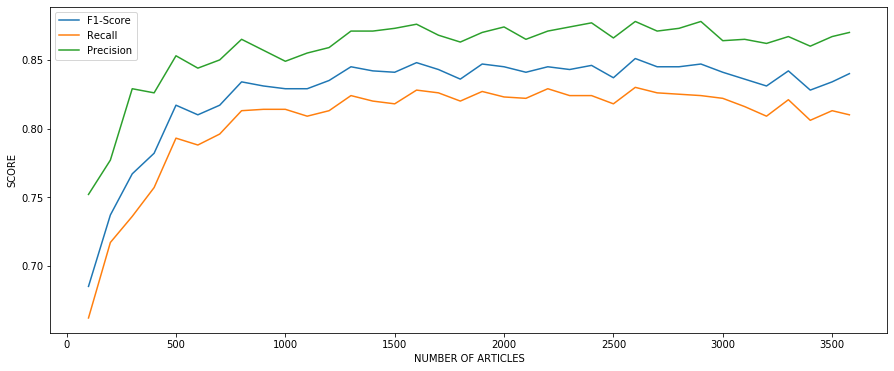

In [181]:
plt.figure(figsize=(15,6))
plt.plot(ran,dev_r['f'],label="F1-Score")
plt.plot(ran,dev_r['r'],label="Recall")
plt.plot(ran,dev_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

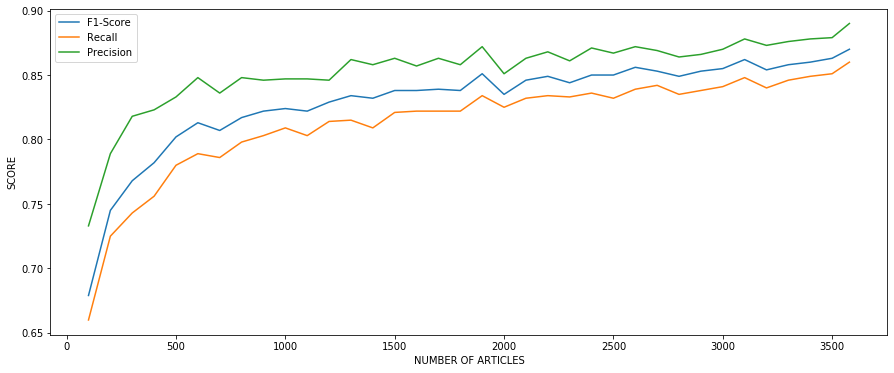

In [182]:
plt.figure(figsize=(15,6))
plt.plot(ran,test_r['f'],label="F1-Score")
plt.plot(ran,test_r['r'],label="Recall")
plt.plot(ran,test_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

### Change Only Ratio of a Class

In [37]:
t_0 = train[train.label == 0.0]

t_1 = train[train.label == 1.0]

### Class 0

In [31]:
ran = list(range(856,2723,500))
ran.append(2723)

dev_r = {"p":[],"r":[],"f":[]}
test_r = {"p":[],"r":[],"f":[]}

for r in ran:
    d_p,d_r,d_f = [],[],[]
    t_p,t_r,t_f = [],[],[]
    for _ in range(10):
        t = pd.concat([t_0.sample(r,random_state=random.sample(range(100),1)[0]),t_1]).sample(r+856)
        svc_model = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
        ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

        svc_model.fit(t.text, list(t.label))
    
        d_res = classification_report(list(dev.label),svc_model.predict(dev.text)).split('\n')[6].split('      ')[1:-1]
        d_p.append(float(d_res[0]))
        d_r.append(float(d_res[1]))
        d_f.append(float(d_res[2]))
        
        t_res = classification_report(list(test.label),svc_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]
        t_p.append(float(t_res[0]))
        t_r.append(float(t_res[1]))
        t_f.append(float(t_res[2]))
        
    dev_r["p"].append(sum(d_p)/len(d_p))
    dev_r["r"].append(sum(d_r)/len(d_r))
    dev_r["f"].append(sum(d_f)/len(d_f))
    
    test_r["p"].append(sum(t_p)/len(t_p))
    test_r["r"].append(sum(t_r)/len(t_r))
    test_r["f"].append(sum(t_f)/len(t_f))

filename = 'dev_r_class0.pickle'
pickle.dump(dev_r, open("../data/"+filename, 'wb'))

filename = 'test_r_class0.pickle'
pickle.dump(test_r, open("../data/"+filename, 'wb'))

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ran,dev_r['f'],label="F1-Score")
plt.plot(ran,dev_r['r'],label="Recall")
plt.plot(ran,dev_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

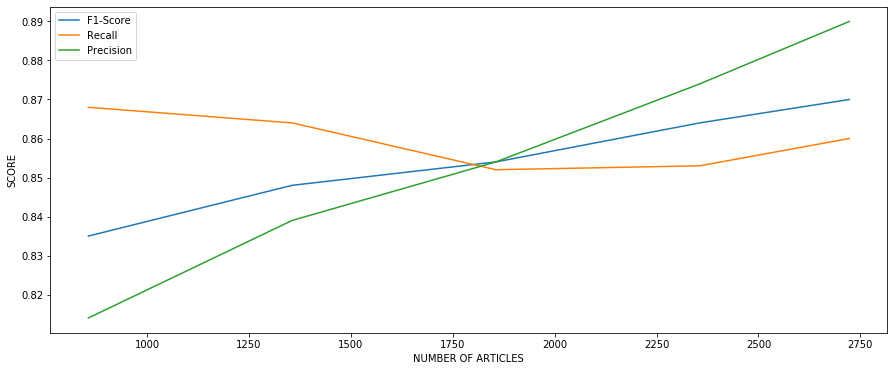

In [33]:
plt.figure(figsize=(15,6))
plt.plot(ran,test_r['f'],label="F1-Score")
plt.plot(ran,test_r['r'],label="Recall")
plt.plot(ran,test_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

### Class 1

In [36]:
ran = list(range(100,856,100))
ran.append(856)

In [38]:

dev_r = {"p":[],"r":[],"f":[]}
test_r = {"p":[],"r":[],"f":[]}

for r in ran:
    d_p,d_r,d_f = [],[],[]
    t_p,t_r,t_f = [],[],[]
    for _ in range(3):
        t = pd.concat([t_1.sample(r,random_state=random.sample(range(100),1)[0]),t_0]).sample(r+2723)
        svc_model = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 4,ngram_range = (1, 2))),
        ('clf', SVC(kernel="linear",gamma="scale",C =10,probability=1))])

        svc_model.fit(t.text, list(t.label))
    
        d_res = classification_report(list(dev.label),svc_model.predict(dev.text)).split('\n')[6].split('      ')[1:-1]
        d_p.append(float(d_res[0]))
        d_r.append(float(d_res[1]))
        d_f.append(float(d_res[2]))
        
        t_res = classification_report(list(test.label),svc_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]
        t_p.append(float(t_res[0]))
        t_r.append(float(t_res[1]))
        t_f.append(float(t_res[2]))
        
    dev_r["p"].append(sum(d_p)/len(d_p))
    dev_r["r"].append(sum(d_r)/len(d_r))
    dev_r["f"].append(sum(d_f)/len(d_f))
    
    test_r["p"].append(sum(t_p)/len(t_p))
    test_r["r"].append(sum(t_r)/len(t_r))
    test_r["f"].append(sum(t_f)/len(t_f))

In [39]:
filename = 'dev_r_class1.pickle'
pickle.dump(dev_r, open("../data/"+filename, 'wb'))

filename = 'test_r_class1.pickle'
pickle.dump(test_r, open("../data/"+filename, 'wb'))

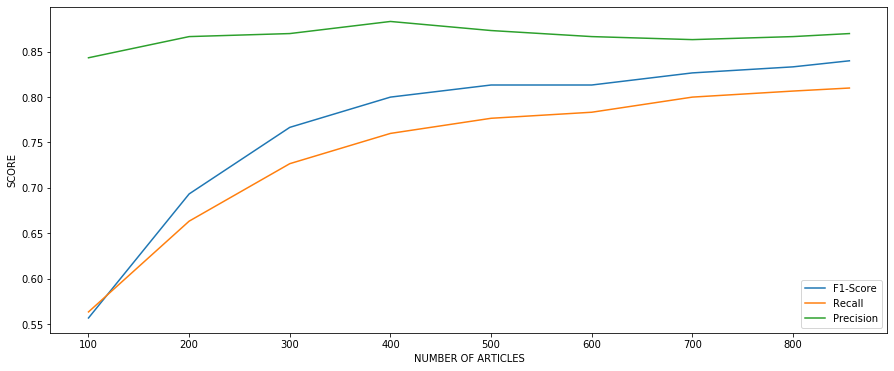

In [40]:
plt.figure(figsize=(15,6))
plt.plot(ran,dev_r['f'],label="F1-Score")
plt.plot(ran,dev_r['r'],label="Recall")
plt.plot(ran,dev_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

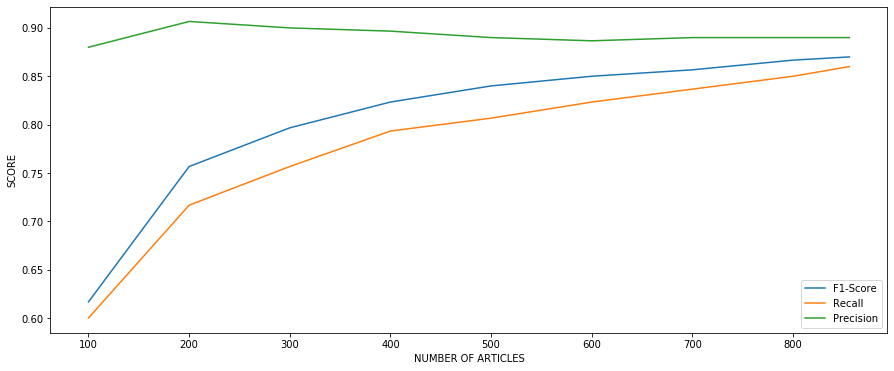

In [41]:
plt.figure(figsize=(15,6))
plt.plot(ran,test_r['f'],label="F1-Score")
plt.plot(ran,test_r['r'],label="Recall")
plt.plot(ran,test_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

## 2.2 Naive Bayes and Experiments

In [19]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [28]:
gnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB()),
])

hyperparameters = dict(
    tfidf__min_df      = (25,50,100),
    tfidf__ngram_range = ((1, 1), (1, 2), (1, 3))
)

gnb_grid_search = GridSearchCV(gnb_pipeline, hyperparameters,cv=5,scoring='f1_macro')

gnb_grid_search.fit(train.text, list(train.label))

gnb_grid_search.best_score_

0.737742091363226

In [29]:
gnb_grid_search.best_params_

{'tfidf__min_df': 25, 'tfidf__ngram_range': (1, 1)}

### All Data

In [41]:
ran = list(range(100,3579,100))
ran.append(3579)

dev_r = {"p":[],"r":[],"f":[]}
test_r = {"p":[],"r":[],"f":[]}

for r in ran:
    d_p,d_r,d_f = [],[],[]
    t_p,t_r,t_f = [],[],[]
    for _ in range(10):
        t = train.sample(r,random_state=random.sample(range(100),1)[0])
        
        gnb_model = Pipeline([
            ('tfidf', TfidfVectorizer(min_df = 25, ngram_range=(1,1))),
            ('to_dense', DenseTransformer()),
            ('clf', GaussianNB()),
        ])

        gnb_model.fit(t.text, list(t.label))
    
        d_res = classification_report(list(dev.label),gnb_model.predict(dev.text)).split('\n')[6].split('      ')[1:-1]
        d_p.append(float(d_res[0]))
        d_r.append(float(d_res[1]))
        d_f.append(float(d_res[2]))
        
        t_res = classification_report(list(test.label),gnb_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]
        t_p.append(float(t_res[0]))
        t_r.append(float(t_res[1]))
        t_f.append(float(t_res[2]))
        
    dev_r["p"].append(sum(d_p)/len(d_p))
    dev_r["r"].append(sum(d_r)/len(d_r))
    dev_r["f"].append(sum(d_f)/len(d_f))
    
    test_r["p"].append(sum(t_p)/len(t_p))
    test_r["r"].append(sum(t_r)/len(t_r))
    test_r["f"].append(sum(t_f)/len(t_f))

In [42]:
filename = 'dev_r_gnb.pickle'
pickle.dump(dev_r, open("../data/"+filename, 'wb'))

filename = 'test_r_gnb.pickle'
pickle.dump(test_r, open("../data/"+filename, 'wb'))

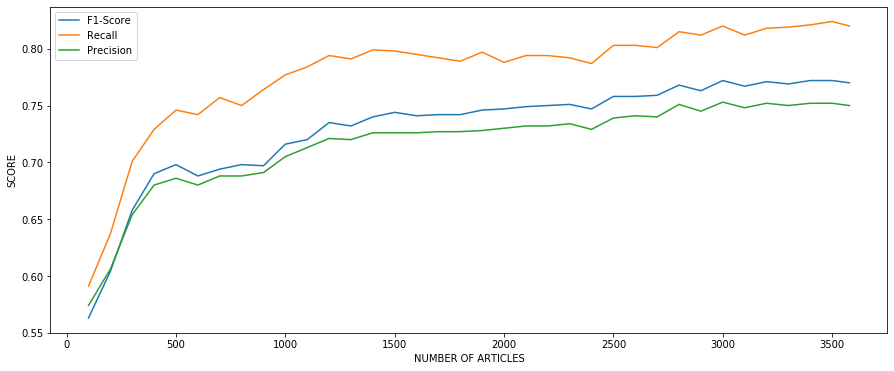

In [43]:
plt.figure(figsize=(15,6))
plt.plot(ran,dev_r['f'],label="F1-Score")
plt.plot(ran,dev_r['r'],label="Recall")
plt.plot(ran,dev_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

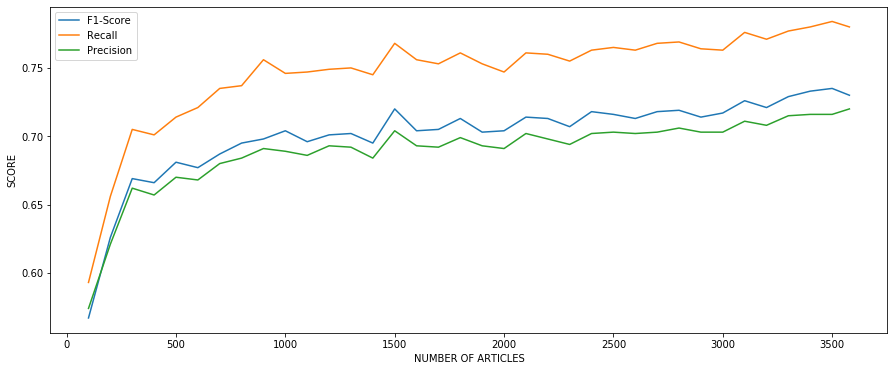

In [44]:
plt.figure(figsize=(15,6))
plt.plot(ran,test_r['f'],label="F1-Score")
plt.plot(ran,test_r['r'],label="Recall")
plt.plot(ran,test_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

### Class 0

In [45]:
ran = list(range(856,2723,500))
ran.append(2723)

dev_r = {"p":[],"r":[],"f":[]}
test_r = {"p":[],"r":[],"f":[]}

for r in ran:
    d_p,d_r,d_f = [],[],[]
    t_p,t_r,t_f = [],[],[]
    for _ in range(10):
        
        t = pd.concat([t_0.sample(r,random_state=random.sample(range(100),1)[0]),t_1]).sample(r+856)
        
        gnb_model = Pipeline([
            ('tfidf', TfidfVectorizer(min_df = 25, ngram_range=(1,1))),
            ('to_dense', DenseTransformer()),
            ('clf', GaussianNB()),
        ])

        gnb_model.fit(t.text, list(t.label))
    
        d_res = classification_report(list(dev.label),gnb_model.predict(dev.text)).split('\n')[6].split('      ')[1:-1]
        d_p.append(float(d_res[0]))
        d_r.append(float(d_res[1]))
        d_f.append(float(d_res[2]))
        
        t_res = classification_report(list(test.label),gnb_model.predict(test.text)).split('\n')[6].split('      ')[1:-1]
        t_p.append(float(t_res[0]))
        t_r.append(float(t_res[1]))
        t_f.append(float(t_res[2]))
        
    dev_r["p"].append(sum(d_p)/len(d_p))
    dev_r["r"].append(sum(d_r)/len(d_r))
    dev_r["f"].append(sum(d_f)/len(d_f))
    
    test_r["p"].append(sum(t_p)/len(t_p))
    test_r["r"].append(sum(t_r)/len(t_r))
    test_r["f"].append(sum(t_f)/len(t_f))
        
filename = 'dev_r_gnb_class0.pickle'
pickle.dump(dev_r, open("../data/"+filename, 'wb'))

filename = 'test_r_gnb_class0.pickle'
pickle.dump(test_r, open("../data/"+filename, 'wb'))

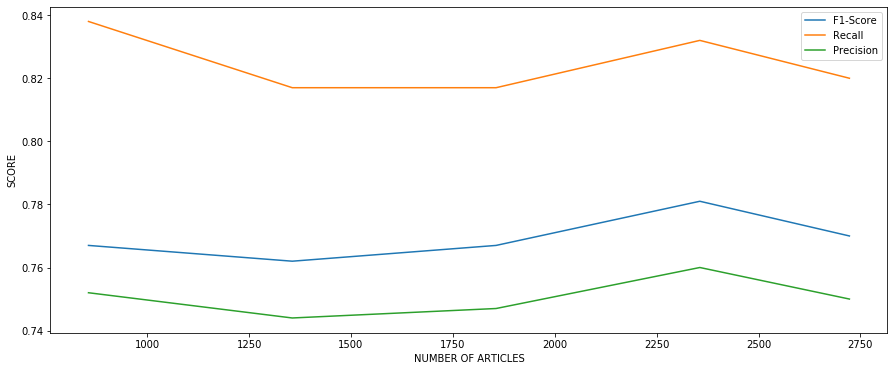

In [46]:
plt.figure(figsize=(15,6))
plt.plot(ran,dev_r['f'],label="F1-Score")
plt.plot(ran,dev_r['r'],label="Recall")
plt.plot(ran,dev_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

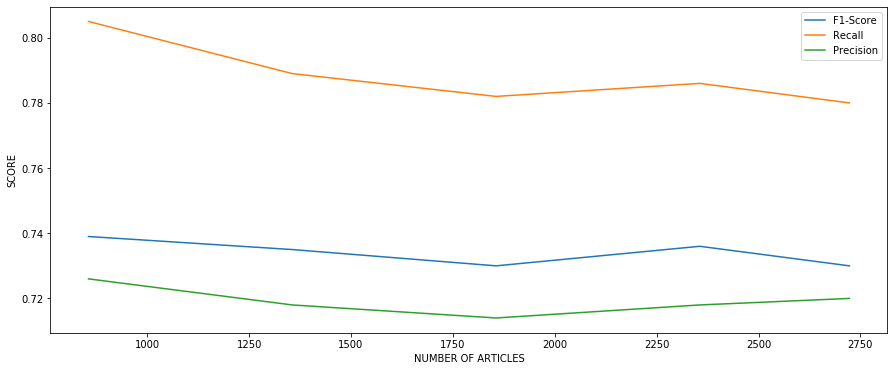

In [47]:
plt.figure(figsize=(15,6))
plt.plot(ran,test_r['f'],label="F1-Score")
plt.plot(ran,test_r['r'],label="Recall")
plt.plot(ran,test_r['p'],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

# ULTIMATE EXPERIMENT FUNCTIONS

In [49]:
train.shape[0]

3579

In [77]:
def svm_none(train_dataframe,test_dataframe,dev_dataframe=None,step=100):
    
    text = train_dataframe.text
    label = list(train_dataframe.label)
    if str(type(dev_dataframe)) == "<class 'pandas.core.frame.DataFrame'>":
        d_text = dev_dataframe.text
        d_label = list(dev_dataframe.label)

    t_text = test_dataframe.text
    t_label = list(test_dataframe.label)
    
    
    
    
    ran = list(range(step,train_dataframe.shape[0],step))
    ran.append(train_dataframe.shape[0])

    svm_none_dev_r = {"p":[],"r":[],"f":[]}
    svm_none_test_r = {"p":[],"r":[],"f":[]}

    for r in ran:
        d_p,d_r,d_f = [],[],[]
        t_p,t_r,t_f = [],[],[]
        for _ in range(5):
            r_state = random.sample(range(100),1)[0]
            t = train.sample(r,random_state = r_state)
            
            # START: Create GridSearch Part
            svc_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SVC()),
            ])

            hyperparameters = dict(
                tfidf__min_df      = (4, 10, 16),
                tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
                clf__kernel        = ["linear", "poly","sigmoid"],
                clf__C             = np.logspace(1,3,3)

            )

            svc_grid_search = GridSearchCV(svc_pipeline, hyperparameters,cv=3,scoring='f1_macro')
            svc_grid_search.fit(text, label)
            
            #END
            svm_model = Pipeline(**svc_grid_search.best_params_)
            
            if str(type(dev_dataframe)) == "<class 'pandas.core.frame.DataFrame'>":
                d_res = classification_report((d_label),svm_model.predict(d_text)).split('\n')[6].split('      ')[1:-1]
                d_p.append(float(d_res[0]))
                d_r.append(float(d_res[1]))
                d_f.append(float(d_res[2]))

            t_res = classification_report((t_label),gnb_model.predict(t_text)).split('\n')[6].split('      ')[1:-1]
            t_p.append(float(t_res[0]))
            t_r.append(float(t_res[1]))
            t_f.append(float(t_res[2]))

        svm_none_dev_r["p"].append(d_p)
        svm_none_dev_r["r"].append(d_r)
        svm_none_dev_r["f"].append(d_f)

        svm_none_test_r["p"].append(t_p)
        svm_none_test_r["r"].append(t_r)
        svm_none_test_r["f"].append(t_f)
        
        
    return svm_none_dev_r,svm_none_test_r

In [79]:
d_svm_none,t_svm_none = svm_none(train,test,dev,step=200)

filename = 'dev_r_svm_none.pickle'
pickle.dump(d_svm_none, open("../data/"+filename, 'wb'))

filename = 'test_r_svm_none.pickle'
pickle.dump(t_svm_none, open("../data/"+filename, 'wb'))

TypeError: __init__() got an unexpected keyword argument 'clf__C'

In [ ]:
def svm_class(cls,train_dataframe,test_dataframe,dev_dataframe=None,step=100):
    
    text = train_dataframe.text
    label = list(train_dataframe.label)
    if str(type(dev_dataframe)) == "<class 'pandas.core.frame.DataFrame'>":
        d_text = dev_dataframe.text
        d_label = list(dev_dataframe.label)

    t_text = test_dataframe.text
    t_label = list(test_dataframe.label)
    
    
    
    
    ran = list(range(step,train_dataframe.shape[0],step))
    ran.append(train_dataframe.shape[0])

    svm_none_dev_r = {"p":[],"r":[],"f":[]}
    svm_none_test_r = {"p":[],"r":[],"f":[]}

    for r in ran:
        d_p,d_r,d_f = [],[],[]
        t_p,t_r,t_f = [],[],[]
        for _ in range(5):
            r_state = random.sample(range(100),1)[0]
            t = train.sample(r,random_state = r_state)
            
            # START: Create GridSearch Part
            svc_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SVC()),
            ])

            hyperparameters = dict(
                tfidf__min_df      = (4, 10, 16),
                tfidf__ngram_range = ((1, 1), (1, 2), (1, 3)),
                clf__kernel        = ["linear", "poly","sigmoid"],
                clf__C             = np.logspace(1,3,3)

            )

            svc_grid_search = GridSearchCV(svc_pipeline, hyperparameters,cv=3,scoring='f1_macro')
            svc_grid_search.fit(text, label)
            
            #END
            svm_model = Pipeline(**svc_grid_search.best_params_)
            
            if str(type(dev_dataframe)) == "<class 'pandas.core.frame.DataFrame'>":
                d_res = classification_report((d_label),svm_model.predict(d_text)).split('\n')[6].split('      ')[1:-1]
                d_p.append(float(d_res[0]))
                d_r.append(float(d_res[1]))
                d_f.append(float(d_res[2]))

            t_res = classification_report((t_label),gnb_model.predict(t_text)).split('\n')[6].split('      ')[1:-1]
            t_p.append(float(t_res[0]))
            t_r.append(float(t_res[1]))
            t_f.append(float(t_res[2]))

        svm_none_dev_r["p"].append(d_p)
        svm_none_dev_r["r"].append(d_r)
        svm_none_dev_r["f"].append(d_f)

        svm_none_test_r["p"].append(t_p)
        svm_none_test_r["r"].append(t_r)
        svm_none_test_r["f"].append(t_f)
        
        
    return svm_none_dev_r,svm_none_test_r

In [ ]:
def main(model_name,which_class=None,step=100,train_dataframe,test_dataframe,dev_dataframe=None):
    
    text = train_dataframe.text
    label = list(train_dataframe.label)
    
    if model_name == "svm":
        if which_class == None:
            return which_class_none()
            
            
        